In [1]:
#libraries and data import - needed for later code, will figure out to try and hide this later
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

data_dir = "/Users/jonathanzhu/Documents/data/"

text_file_name = "osdg-community-data-v2023-01-01.csv"
text_df = pd.read_csv(data_dir + text_file_name,sep = "\t",  quotechar='"')
col_names = text_df.columns.values[0].split('\t')
text_df[col_names] = text_df[text_df.columns.values[0]].apply(lambda x: pd.Series(str(x).split("\t")))
text_df = text_df.astype({'sdg':int, 'labels_negative': int, 'labels_positive':int, 'agreement': float}, copy=True)

#preprocessing - will hide later
from googletrans import Translator
from langdetect import detect
text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2")
text_df.reset_index(inplace=True, drop=True)
text_df["lang"] = text_df["text"].apply(lambda x: detect(x))

font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}

def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    for labelid in classlabel:
        feature_names = vectorizer.get_feature_names_out()
        top_n = sorted(zip(classifier.feature_log_prob_[labelid], feature_names), reverse=True)[:n]
        for coef, feat in top_n:
            print("SDG {} : {:30}  {:.6}".format(labelid, feat, coef))
        print("")
def print_top_n_features(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        top_n = np.argsort(clf.feature_log_prob_[i])[::-1][:n]
        print("%s: %s" % (class_label,
              " || ".join(feature_names[j] for j in top_n)))

```{index} Machine learning
```

# 4. Classification of Texts

Now that we have gone through the arduous process of preprocessing, transforming, and embedding our text data, we can finally get into some of the was we can work with it, most prominent of which is classification. In the case of our UN SDG dataset, our goal is to classify documents by the goal they match with. In this subsection, we will briefly review the general process of machine learning before going into some of the methods by which text data are commonly classified.

## 4.1 A Machine Learning Overview

Machine learning of any kind can be boiled down to the process by which we train a machine to make the most effective predictions. When we train a machine to make numerical predictions, we perform <b>regression</b>; if we train a machine to categorize data into categories, we perform <b>classification</b>. Since our UN SDG dataset is classified into the categories of the goals, we will focus on classification.

There are two main types of machine learning: <b>supervised</b> and <b>unsupervised</b>. Supervised learning means that the data we give the machine is already labeled with the "correct" value or category, while unsupervised learning means that the data is unlabeled and there is no "correct" value or category. Here, since our UN SDG data is already labeled with the goal it aligns most with, we consider it supervised. As such, the goal for the machine is to match the "correct" labels of the data we give it.

Machine learning starts with a dataset; with modern advances in data collection and storage, machine learning datasets typically involve thousands of data points, while some industry machine learning projects have access to more powerful computers and can use datasets with millions of data points. This dataset is split into a <b>training set</b> and a <b>testing set</b>. The training set consists of the data fed to the machine for it to build its model, while the testing set consists of data kept separate to evaluate the model's performance. Typically, the training set consists of more data than the testing set; it is common to split the main set 70/30 (70% training, 30% testing) or 80/20.

When a machine builds it predictive model, we need to understand that no machine is perfect at predicting (though some can get pretty close). As such, the main goal of an algorithm when given the training set is to <b>minimize error</b>. The process of error minimization varies between algorithms; one common process is gradient descent, which aims to find a minimum for the error function (a function which determines the error based on the function's internal parameters). 

However, to truly judge the efficacy of the algorithm, we must use data that the algorithm has not yet seen. Hence, the testing set is used to evaluate the algorithm's performance on data similar (but different) from the training set. As data scientists, our goal would be to maximize the performance on the testing set, and we do so by several means discussed in section 5.

For working with all the algorithms, we will use the same train/test split of 66/33:


In [2]:
docs = text_df.text
categories = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(docs, categories, test_size=0.33, random_state=7)

We then vectorize using TF-IDF from the previous section; for this, we are using bi-grams. Unigrams will be given as exercises throughout the section.

In [3]:
X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2), stop_words = "english", min_df=5)
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train)
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test)

```{index} Perceptron
```

## 4.2 The Algorithms

Many algorithms exist for machine learning predictions. Some, like the Support Vector Machine and Linear/Multiple Regression, have existed for a long time and are applicable to a wide range of problems, while others are more recent and are meant to be high-performance on more specific problems. Here, we present three algorithms most commonly used to classify text data.

### 4.2.1 The Perceptron
In 1943, McCulloch & Pitts developed the first Perceptron, called the Neuron Model. This model was first used in 1958 by Frank Rosenblatt, who formed the classical perceptron model, and in 1969, Minsky and Papert published extensive research on the perceptron model. 

The single perceptron is a binary classifier and takes each input $x_i$ and multiplies it by some corresponding weight $w_i$. These are then added for all $x$ and $w$, or $\sum_{i=1}^{N} x_iw_i$. This sum is compared to a threshold $T$, producing an output of 0 if below $T$ or 1 if above $T$. 


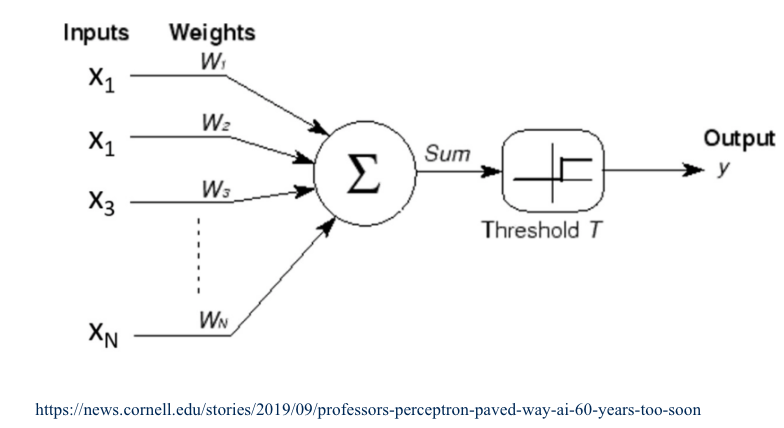

In [1]:
from IPython.display import Image
Image(filename='images/sec3_perceptron.png')

This kind of function is called an activation function, which generally involve a value of 0  or -1 until a threshold $O$ is reached, after which the function stays at 1 or increases. Alternative activation functions include logistic regression (below middle) or the rectified linear unit (ReLU) (below right), with the perceptron at bottom left for reference. 

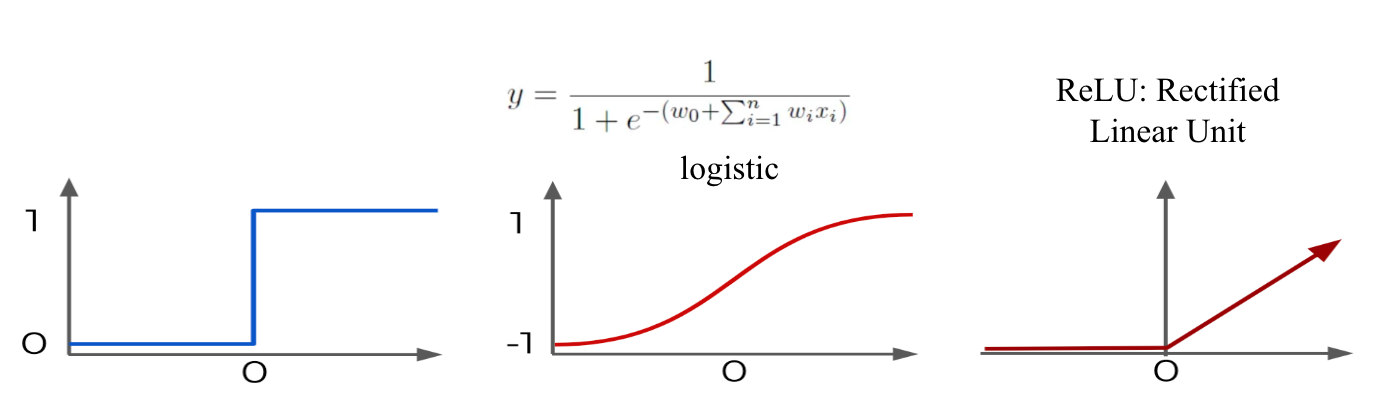

In [2]:
Image(filename='images/sec3_activ_funcs.png')

It was proven relatively quickly that in addition to only being a binary classifier, the perceptron can only handle linearly separable data. These problems can be fixed by using a multilayer perceptron. 

Multilayer perceptrons combine several perceptrons in at least one hidden layer, each layer feeding the results of the neurons to next layer; the components of the final hidden layer then go on to form the output. Unlike single perceptrons, multilayer perceptrons can handle non-linear data and represent arbitrary decision boundaries.

To calculate the weights for each layer, we first compute the errors at the output layer with a cost function.  These errors are then distributed backwards from each layer to the previous layer. Then we use gradient descent on the error functions to adjust weight at the layer, so we need all functions differentiable; the weights that minimize the error function form the solution to the weights for the perceptron.

Once we have our vectorized data ready to go, we can easily apply $\texttt{MLPClassifier()}$ to our training set then evaluate it on the testing set. Our libraries already have built-in functions to report various metrics, which are expanded more in the next section. For now, we only need to look at accuracy.

In [4]:
tfidf_mlp_clf = MLPClassifier(random_state=1, max_iter=100).fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_mlp_clf.predict(X_test_tfidf_vector)
tfidf_mlp_clf.score(X_test_tfidf_vector, y_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.78      0.74      0.76       481
           2       0.50      0.68      0.58       316
           3       0.77      0.84      0.81       674
           4       0.84      0.83      0.83       863
           5       0.81      0.85      0.83       920
           6       0.80      0.82      0.81       465
           7       0.78      0.81      0.80       730
           8       0.54      0.38      0.45       353
           9       0.54      0.56      0.55       328
          10       0.51      0.47      0.49       256
          11       0.65      0.67      0.66       462
          12       0.67      0.51      0.58       217
          13       0.77      0.74      0.76       443
          14       0.68      0.66      0.67       263
          15       0.76      0.68      0.72       313
          16       0.94      0.93      0.93      1057

    accuracy                           0.76      8141
   macro avg       0.71   

```{index} Naive Bayes algorithms
```

<b>Exercise 4.1</b>: Repeat the above classification on unigrams and report the accuracy.

### 4.2.2 Naive Bayes Algorithms

Naive Bayes Algorithms are so called as they rely on Bayes' Theorem and assume high levels of independence (naive). Bayes' Theorem states that 

$P(y|X) = \frac{P(X|y) * P(y)}{P(X)}$.

In terms of Bayesian Probability, $P(y|X)$ is called the <i>posterior</i>, $P(X|y)$ is called the <i>data likelihood</i>, $P(y)$ is the <i>prior</i>, and $P(X)$ is the <i>normalization</i>. In the context of NLP classification, we define $X$ to be the document features and $y$ to be the document's class label. We also assume conditional independence, which means that the class label of one document does not depend on the class label of another document.

We define $\underset{a}{\arg \max} f$ to be the value of $a$ such that the function $f$ is maximized. Then, Naive Bayes Algorithms classify a document into a class $\hat{y}$ by calculating

$\hat{y} = \underset{y}{\arg \max} P(y|X) = \underset{y}{\arg \max} P(X|y)*P(y)$.

Note that when using Naive Bayes, we have the assumption that features are independent given class. This allows us to compute

$P(x_1, x_2, …, x_n |y) = \Pi_{i=1}^{n} P(x_i|y)$

We can estimate either side of this equation with training data, but estimating the right hand side $\Pi_{i=1}^{n} P(x_i|y)$ leads to a much greater reduction of computation.

Similar to the perceptron, we fit the Naive Bayes algorithm to our training and testing set and report metrics:

In [5]:
tfidf_multinomialNB_clf = MultinomialNB().fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_multinomialNB_clf.predict(X_test_tfidf_vector)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.74      0.74      0.74       481
           2       0.85      0.44      0.58       316
           3       0.82      0.84      0.83       674
           4       0.68      0.90      0.78       863
           5       0.63      0.89      0.74       920
           6       0.86      0.81      0.83       465
           7       0.61      0.89      0.72       730
           8       0.81      0.11      0.19       353
           9       0.83      0.23      0.37       328
          10       0.87      0.23      0.36       256
          11       0.78      0.61      0.68       462
          12       0.93      0.29      0.44       217
          13       0.78      0.74      0.76       443
          14       0.93      0.35      0.51       263
          15       0.91      0.50      0.64       313
          16       0.68      0.98      0.80      1057

    accuracy                           0.71      8141
   macro avg       0.79   

```{index} Ridge classification
```

<b>Exercise 4.2</b>: Repeat the above classifications on unigrams and report the accuracy.

### 4.2.3 Ridge Classification

Ridge Classification was designed with the original intent of a restriction on basic multiple linear regression; in essence, it adds an additional penalty for extremely large errors, so ridge regression minimizes more than just the least square residuals. However, ridge algorithms can also be used for classification, and in the context of NLP tasks, ridge classifications have been found to perform very well.

In the binary case, ridge converts the two classes to either 1 or -1 and then treats the problem as a regression problem. This can then be generalized to multiple classes with a One vs. Rest approach, where we make an algorithm to determine if an item is in one specific class or any of the rest of the classes; this is then repeated until any item can be classified into a single class.

More on the ways ridge regression is performed and calculated for classification can be found on the scikit-learn explanation: https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression.

Again, similar to previous classification methods, we run a ridge classification as follows:

In [6]:
from sklearn.linear_model import RidgeClassifier

tfidf_ridge_clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
tfidf_ridge_clf = tfidf_ridge_clf.fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_ridge_clf.predict(X_test_tfidf_vector)
print(metrics.classification_report(y_test,y_pred, digits = 4))

              precision    recall  f1-score   support

           1     0.7160    0.7651    0.7397       481
           2     0.6542    0.6646    0.6593       316
           3     0.8196    0.8427    0.8310       674
           4     0.7558    0.8714    0.8095       863
           5     0.8287    0.8728    0.8502       920
           6     0.8239    0.8151    0.8195       465
           7     0.7995    0.8247    0.8119       730
           8     0.5738    0.3853    0.4610       353
           9     0.5801    0.5518    0.5656       328
          10     0.5990    0.4492    0.5134       256
          11     0.7111    0.6926    0.7018       462
          12     0.7073    0.5346    0.6089       217
          13     0.7817    0.7923    0.7870       443
          14     0.7445    0.6426    0.6898       263
          15     0.7857    0.6677    0.7219       313
          16     0.8920    0.9612    0.9253      1057

    accuracy                         0.7732      8141
   macro avg     0.7358   

<b>Exercise 4.3</b>: Repeat the above classification on unigrams and report the accuracy.

## 4.3 More Exercises

<b>Exercise 4.4</b>: Write a function that takes a document corpus, processed like in the exercises in Section 1, splits the set into a training and testing set, and runs a classifier on the training set then reports metrics on the testing set.
 - Your function should take a parameter $\texttt{classifier\_algorithm}$ that specifies the algorithm to use as well as the parameters necessary for that algorithm.

<b>Exercise 4.5</b>: Run your function on the SDG corpus using Multinomial Naive Bayes, Multilayer Perceptron, and Ridge Regression.
 - Use $\texttt{min\_df}$ to modify the computation time for Multilayer Perceptron; this will reduce the amount of time it takes to run.